## Gaussian pulse moving through dielectric $\varepsilon$ and absorbing $\sigma$ layers

A **Perfectly Matched Layer (PML)** is an artificial absorbing layer used in finite-difference and finite-element electromagnetic simulations (e.g., FDTD, FIT) to mimic open boundaries by preventing reflections at the edges of the computational domain. 

The PML works by **transforming the coordinates into a complex space**, which attenuates outgoing waves without reflection. To achieve this, the **electrical conductivity $ \sigma $** (and magnetic conductivity $ \sigma^* $ if needed) inside the PML is gradually increased along the thickness of the layer — typically using a polynomial ramp such as:

$$
\sigma(x) = \sigma_{\text{max}} \left( \frac{x}{d} \right)^m
$$

where $ x $ is the depth into the PML, $ d $ is the total PML thickness, $ \sigma_{\text{max}} $ is the peak conductivity, and $ m $ (commonly 2–4) controls the smoothness of the ramp. This graded profile ensures impedance matching and gradual absorption, minimizing reflections across a wide frequency range and for oblique incidence.


![](https://codimd.web.cern.ch/uploads/upload_377b25730e2b4ec04c803bbab82562da.gif)

### Simulation with wakis

In [1]:
from scipy.constants import c as c_light
import numpy as np
from tqdm import tqdm

from wakis.solverFIT3D import SolverFIT3D
from wakis.gridFIT3D import GridFIT3D
from wakis.sources import WavePacket

# Plotting settings
import pyvista as pv
flag_plot_pyvista = True

import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150

%matplotlib ipympl

### Domain definition and absorbing barriers
Generating barriers with gometrically increasing conductivity

In [2]:
# barrier dimensions
lx, ly, lz = 5., 5., 10.

# Domain bounds
xmin, xmax, ymin, ymax, zmin, zmax = -lx/2., lx/2., -ly/2., ly/2., -lz/2.,lz/2.

# Number of mesh cells
Nx = 4
Ny = 4
Nz = 800

# cell size
dx, dy, dz = lx/Nx, ly/Ny, lz/Nz

# Barriers
barrier = {}
stl_solids = {}
stl_materials = {}

n = 16
ss = np.linspace( np.sqrt(1.e-4), np.sqrt(1.e-1), n, )
ss = ss*ss

width = 2.*dz
pos_z_begin = zmax - n*width

for k, si in enumerate(ss):
    
    name = f'b{k}'
    file_name = f'data/003_barrier{k}.stl'
    
    barrier[k] = pv.Cube( x_length=lx, y_length=ly, z_length=width, center=(0,0,pos_z_begin+k*width))
    barrier[k].save( file_name, )

    stl_solids[name] = file_name
    stl_materials[name] = [ 1.+si, 1., si, ]

In [3]:
# Simulation grid
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, 
                 Nx, Ny, Nz, 
                 stl_solids=stl_solids, 
                 stl_materials=stl_materials)

if flag_plot_pyvista:
    #grid.plot_solids(bounding_box=True)
    grid.inspect()

Generating grid...
Importing stl solids...


Widget(value='<iframe src="http://localhost:42403/index.html?ui=P_0x7f1c452cbdd0_0&reconnect=auto" class="pyvi…

### Solver setup

In [4]:
# boundary conditions
bc_low=['periodic', 'periodic', 'pec']  
bc_high=['periodic', 'periodic', 'pec']

solver = SolverFIT3D(grid=grid,     # pass grid object
                     cfln=0.50,       # Default if no dt is defined
                     bc_low=bc_low, 
                     bc_high=bc_high, 
                     bg='vacuum',      # Background material 
                     use_stl=True,     # Enables or disables geometry import
                     use_gpu=False,      
                     )


Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.05758333206176758 s


### Source setup

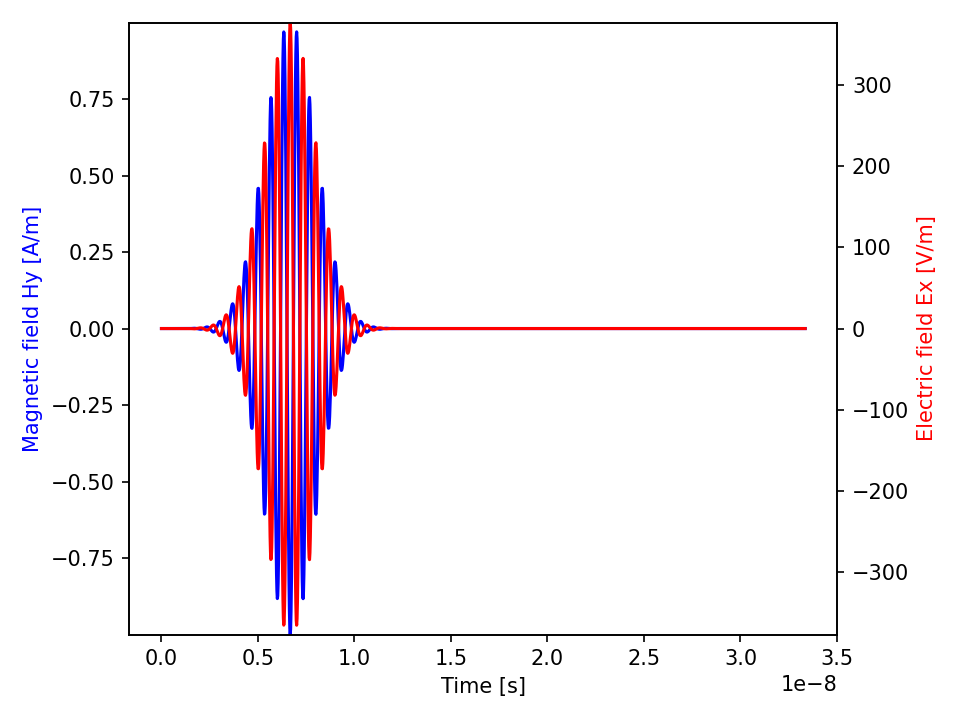

In [5]:
# Add Gaussian wavepacket
source = WavePacket(xs=slice(0,Nx), ys=slice(0,Ny),
                    sigmaxy=100.,
                    sigmaz=.4,
                    wavelength=16.*dz,
                    tinj=2.0,
                    amplitude=1.)

# Plot source in time
t = np.arange(0,(zmax-zmin)/c_light, solver.dt)
source.plot(t)

### Time-stepping

In [6]:
#initialize to 0
for d in ['x','y','z']:
    solver.E[:,:,:,d] = 0.
    solver.H[:,:,:,d] = 0.
    solver.J[:,:,:,d] = 0.

# Fields to save
Ex, Ey, Hx, Hy, Jz = [], [], [], [], []

plot2D = False #Turn on to generate 2d plots on-the-fly!

N1 = 5*int((2+zmax-zmin)/c_light/solver.dt)
for n in tqdm(range(N1)):

    # Apply source
    source.update(solver, solver.dt*n)

    # Advance fields
    solver.one_step()

    if n%100 == 0:
        Ex.append(solver.E[Nx//2, Ny//2, :, 'x'])
        Ey.append(solver.E[Nx//2, Ny//2, :, 'y'])
        Hx.append(solver.H[Nx//2, Ny//2, :, 'x'])
        Hy.append(solver.H[Nx//2, Ny//2, :, 'y'])
        Jz.append(solver.J[Nx//2, Ny//2, :, 'z'])

    if plot2D and n%100 == 0:
        solver.plot2D(field='H', component='y', plane='ZY', pos=0.5, norm='symlog', 
               vmin=-1, vmax=1, figsize=[8,4], cmap='RdBu', patch_alpha=0.1, 
               add_patch=False, off_screen=True, n=n, interpolation='spline36',
               title='notebooks/data/003_Hy',)

100%|██████████| 9600/9600 [00:10<00:00, 893.54it/s]


Animation of the interaction with the PML

MovieWriter ffmpeg unavailable; using Pillow instead.


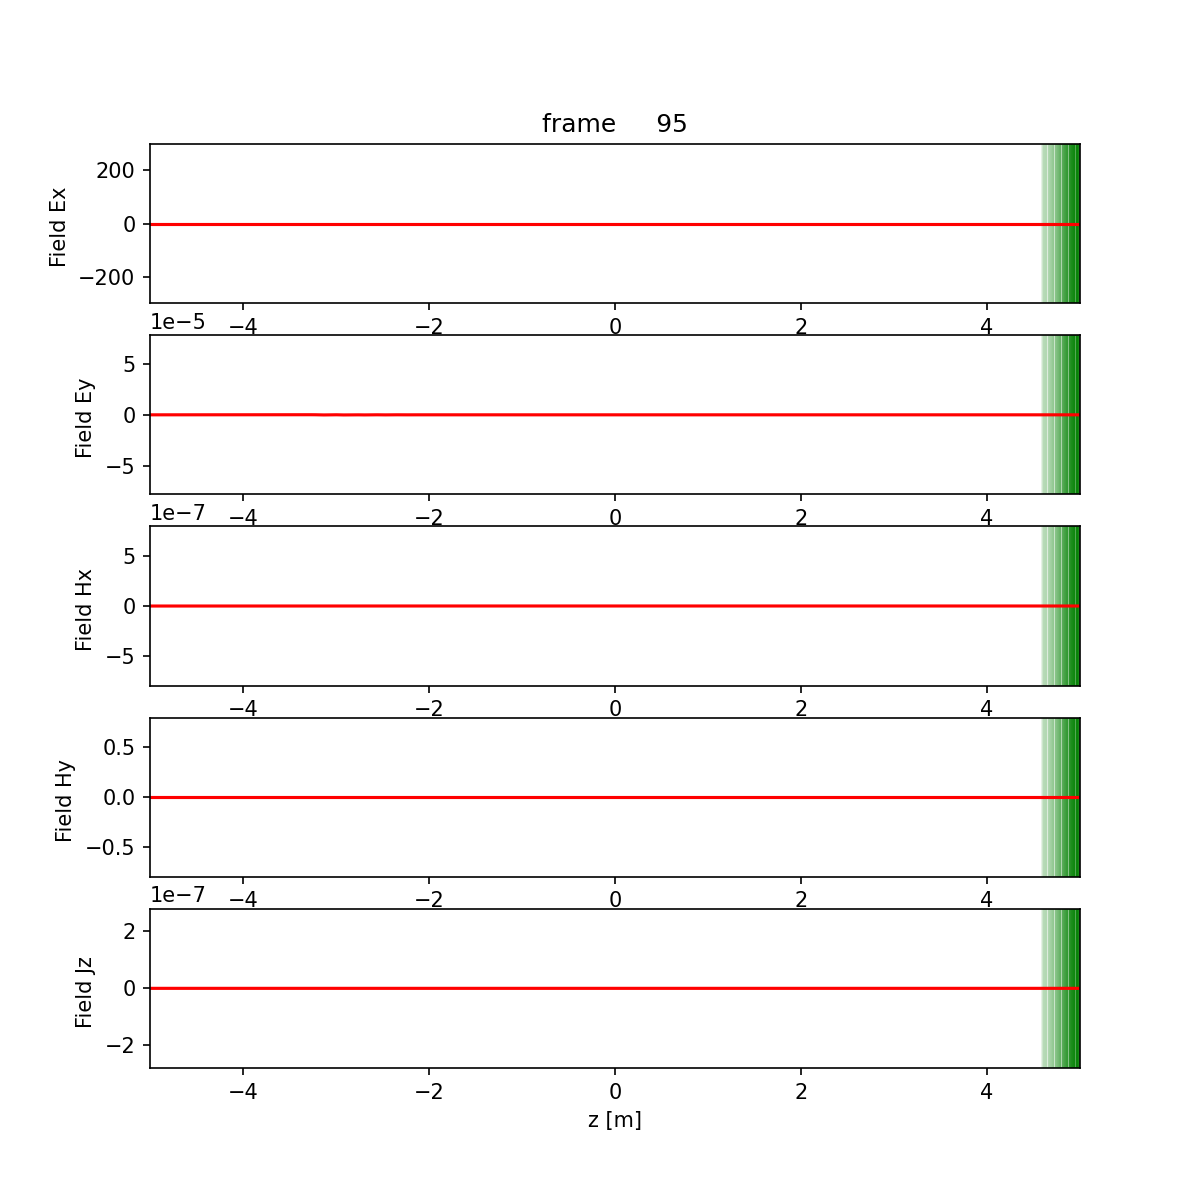

In [ ]:
from argparse import Namespace as NS
from matplotlib import animation

fields = { 
  'Ex': NS( values=np.array(Ex), units='', ), 
  'Ey': NS( values=np.array(Ey), units='', ), 
  'Hx': NS( values=np.array(Hx), units='', ),
  'Hy': NS( values=np.array(Hy), units='', ),
  'Jz': NS( values=np.array(Jz), units='', ),
}

# frames animation
fig, axs = plt.subplots( len(fields), 1, figsize=[8,8], dpi=150, )

axs[-1].set_xlabel(f'z [m]')
for ax, ( ki, vi, ) in zip(axs,fields.items()):

  ax.set_ylabel(f'Field {ki} {vi.units}')

  q = np.abs(vi.values).max()
  ax.set_ylim((-q,q))
  ax.set_xlim((zmin,zmax))
  
  # barriers
  for b, si in zip(barrier.values(),ss):
    xlo, xhi, ylo, yhi, zlo, zhi = b.bounds
    ax.axvspan(zlo, zhi, color='g', alpha=.1 + .6*si/ss.max())

  ls = [ ax.plot(solver.z, np.full_like( solver.z, np.nan, ), c='r')[0] for ax in axs ]

def animate(frame,ls,fields,axs):
  fig.gca()
  axs[0].set_title(f'frame {frame:6d}')
  # field
  for li, ( ki, vi, ) in zip(ls,fields.items()):
    li.set( data=(solver.z,vi.values[frame]), )
  return ls

anim = animation.FuncAnimation(fig, lambda frame: animate(frame,ls,fields,axs), frames=len(vi.values), )
anim.save(f'data/002_movie.gif')
